# File: exercise_0.ipynb
## Description
A Python/PyRoot/RooFit tutorial. Implementation of Glen Cowan's exercise: Fit an exponential to data. 
 - Created: 4 June 2013 Harrison B. Prosper, INFN SOS 2013, Vietri sul Mare, Italy
 - Adapted for CMSDAS 2016, LPC Fermilab, Harrison B. Prosper
 - Adapted for CMSDAS 2019, LPC Fermilab, Javier Duarte
 - Adapted for CMSDAS 2024, LPC Fermilab, Harrison B. Prosper

In [1]:
# Load the operating system and system modules into memory
import os, sys

# Load the sleep function from the time module
from time import sleep
import math

# Load everything that is in PyROOT.
import ROOT

Welcome to JupyROOT 6.28/06


## Suppress all messages except those that matter

In [2]:
msgservice = ROOT.RooMsgService.instance()
# If a crash occurs, or things look strange,
# comment out next line to find out more information
# about the problem.
msgservice.setGlobalKillBelow(ROOT.RooFit.FATAL)

## Create Workspace

In [3]:
# The most convenient way to use RooFit/RooStats is to
# make a workspace so that we can use its factory method
wspace = ROOT.RooWorkspace("CMSDAS")

## Create double-exponential model
The observable is $x$ and the model parameters are $a, b$ and $c$. All entities in **RooFit**, including variables, are objects. We can create a variable using the **factory** method of the workspace as follows,

```python
        wspace.factory(f"{name:s}[{value:f}, {xmin:f}, {xmax:f}]")
```
where `name`, `value`, `xmin`, and `xmax` are the name, value, minimum and maximum values of the variable.

**Example**

```python
    wspace.factory(f"x[{value:f}, {xmin:f}, {xmax:f}]")
```

In [14]:
# The observable is x and lies in the range [0, 20]
xmin =  0.0  # this is a float
xmax = 20.0  # and so is this

# Use the factory method of the RooWorkspace object, just
# created, to create an object called x that represents the
# observable.
# syntax:
#        <name>[value, min-value, max-value]
#
# We are using Python's ability to write numbers into strings,
# which is modeled on C
wspace.factory(f"x[0, {xmin:f}, {xmax:f}]")

# ---------------------------
# Set the NUMBER OF BINS,
# either for display purposes
# or for the binned fit.
# ---------------------------
M = 20
wspace.var("x").setBins(M)

# The parameters of the model are a, b, c
wspace.factory("a[0.4, 0.0,   1.0]")
wspace.factory("b[3.0, 0.01, 20.0]")
wspace.factory("c[9.0, 0.01, 20.0]")
parameters = ["a", "b", "c"]

# NUMBER OF PARAMETERS
P = len(parameters)

## Define Model

$$p(x | a, b, c) = a \exp(-x / b) / b + (1 - a) \exp(-x / c) / c$$

In [15]:
# The model to be fitted, called "model", is defined
# by a probability density function (pdf) of the form
#
#   p(x|a, b, c) = a*exp(-x/b)/b + (1-a)*exp(-x/c)/c
#
# The syntax for creating a pdf, here a user-defined pdf using
# the class RooGenericPdf, is:
#
# GenericPdf::<user-defined-name>("<function>", {...})
#
# where we always drop the "Roo" prefix. Note use of braces {..}
# in the above to specify a list of variables
# (modeled in RooFit by the RooArgList class).
#
# POWERFUL TIP: a function can be a call to a C++
# function (with double and int arguments), compiled
# using
#
#  gROOT.ProcessLine(open('<function>.cc').read())
#
# and made known to Python using
#
#  from ROOT import <function>
#
# The Python file open object reads the specified file as one
# continuous string, which is then passed to ProcessLine. The
# latter compiles it using a just-in-time compiler (in Root 6).
# Since Root 6 uses a real compiler (rather than an interpreter),
# the syntax of your C++ code must conform to standard C++.
#
# If you need to make the compiler and linker happy by including
# headers and libraries other the the default set provided by ROOT,
# first do
#
#   gSystem.AddIncludePath('-I<path1> ...')
#   gSystem.AddLinkedLibs('-L<libdir> -l<library> ...')
#
# before calling gROOT.ProcessLine

# Note use of "\" continuation markers below

# Here is a direct way to create the model:
#
# wspace.factory('GenericPdf::model'\
#                '("a*exp(-x/b)/b + (1-a)*exp(-x/c)/c",'\
#                '{x,a,c,c})')

# and here is a way to do the same thing via a C++ function:

ROOT.gInterpreter.Declare(
    """
#include <cmath>
double dbexp(double x, double a, double b, double c)
{
  return a*exp(-x/b)/b + (1-a)*exp(-x/c)/c;
}
"""
)
from ROOT import dbexp

wspace.factory('GenericPdf::model("dbexp(x,a,b,c)", {x,a,b,c})')


# So far, the "model" is known only to the RooFit workspace.
# Make the model known to Python also
model = wspace.pdf("model")

input_line_151:3:8: error: redefinition of 'dbexp'
double dbexp(double x, double a, double b, double c)
       ^
input_line_69:3:8: note: previous definition is here
double dbexp(double x, double a, double b, double c)
       ^


## Generare some data from the model

In [16]:
# define the set obs = (x)
wspace.defineSet("obs", "x")

# make the set obs known to Python
obs = wspace.set("obs")

# now, generate data
N = 400  # number of data to generate
data = model.generate(obs, N)

## PART 1: Do an unbinned fit of the model to the generated data

In [17]:
print("=" * 80)
print("\t\t unbinned fit to data")
print("=" * 80)

# Obvious, right?!! :)
swatch = ROOT.TStopwatch()
swatch.Start()

# If more control is needed, you can call RooMinuit
# directly, which is an interface to Minuit.
# Here, we are happy to use the simpler interface "fitTo".
# Remember to save the results of the fit
results = model.fitTo(data, ROOT.RooFit.Save())
print("real time: {:.3f} s".format(swatch.RealTime()))

# Let's see what we get
print("=" * 80)
results.Print()

# Print correlation matrix as a matrix.
print("\tcorrelation matrix")
output = "{:10s}".format("")
for v in parameters:
    output += "{:>10s} ".format(v)
output += "\n"
for v1 in parameters:
    output += "{:>10s}".format(v1)  # first print label and suppress a newline
    for v2 in parameters:
        cor = results.correlation(v1, v2)
        output += "{:10.3f} ".format(cor)
    output += "\n"
print(output)

		 unbinned fit to data
real time: 0.013 s
	correlation matrix
                   a          b          c 
         a     1.000      0.786      0.688 
         b     0.786      1.000      0.662 
         c     0.688      0.662      1.000 

 **********
 **   37 **SET PRINT           1
 **********
 **********
 **   38 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a            3.57040e-01  9.24172e-02    0.00000e+00  1.00000e+00
     2 b            2.14186e+00  5.95952e-01    1.00000e-02  2.00000e+01
     3 c            1.32572e+01  5.33267e+00    1.00000e-02  2.00000e+01
 **********
 **   39 **SET ERR         0.5
 **********
 **********
 **   40 **SET PRINT           1
 **********
 **********
 **   41 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **   42 **MIGRAD        1500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=

## Plot results of fit

This is how RooFit makes plots. Alas, it is not as intuitive as it could have been!

We wish to plot the distribution of the data and superimpose the fitted model as a function of the observable $x$.
In RooFit, one does proceeds as follows:
   1. create a frame pertaining to x (which we call xframe)
   1. set the frame's attributes, of which there are many
   1. tell the data to place a plot of themselves on xframe
   1. tell the model to place a plot of itself on xframe
   1. tell the model to place its parameters on xframe
   1. tell the xframe to draw itself on the active canvas

Warning in <TCanvas::Constructor>: Deleting canvas with same name: fig_unbinnedFit
Info in <TCanvas::Print>: png file ./fig_unbinnedFit.png has been created


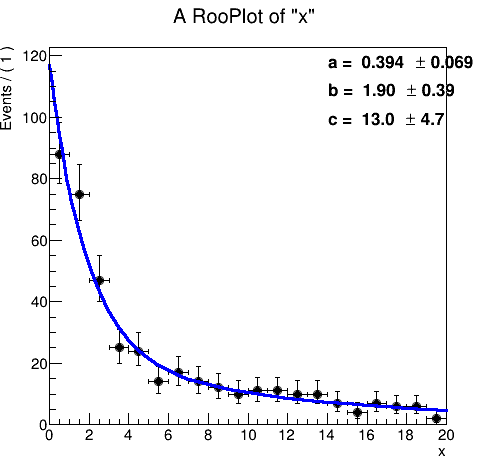

In [18]:
# 1.
xframe = wspace.var("x").frame()
# 2.
xframe.SetMinimum(0)    # set minimum y-axis value
xframe.SetMaximum(100)  # set maximum y-axis value
# 3.
data.plotOn(xframe)
# 4. 
model.plotOn(xframe)
# 5.
model.paramOn(xframe)

# 6.
# If you have trouble making the plot look exactly as you
# wish it to look, try drawing an empty Root histogram
# first in order to define the plotting area, then Draw
# xframe using the "same" option.

c1 = ROOT.TCanvas("fig_unbinnedFit", "fit", 500, 500)
xframe.Draw()
c1.Draw()
c1.SaveAs(".png")

## PART 2: Do a binned fit

The data are binned using an instance of the RooFit class **RooDataHist**. Our model this time will be a multinomial

\begin{align}
p(N_1,\cdots,N_M | a, b, c) & = \binom{N}{N_1\cdots N_M} \prod_{i=1}^M p_i^{N_i}, \text{ where}\\
                          \sum_{i=1}^M p_i & = 1, \\
                          \sum_{i=1}^M N_i & = N, \text{ and}\\
                          \quad p_i & \equiv n_i / N .
\end{align}
The mean counts $n_i$ are functions of the parameters $a, b,$ and $c$. A multinomial model is appropriate if one wants results to be conditioned on a *fixed* total count $N$. If the total count $N$ is unconstrained, the multinomial becomes a multi-Poisson model.

DataStore hdata (binned data)
  Contains 20 entries
  Observables: 
    1)  x = 19.5  L(0 - 20) B(20)  "x"
Binned Dataset hdata (binned data)
  Contains 20 bins with a total weight of 400
  Observables:     1)  x = 19.5  L(0 - 20) B(20)  "x"
 **********
 **   46 **SET PRINT           1
 **********
 **********
 **   47 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a            3.93947e-01  6.91925e-02    0.00000e+00  1.00000e+00
     2 b            1.89656e+00  3.91805e-01    1.00000e-02  2.00000e+01
     3 c            1.30072e+01  4.67120e+00    1.00000e-02  2.00000e+01
 **********
 **   48 **SET ERR         0.5
 **********
 **********
 **   49 **SET PRINT           1
 **********
 **********
 **   50 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **   51 **MIGRAD        1500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLA

Warning in <TCanvas::Constructor>: Deleting canvas with same name: fig_binnedFit
Info in <TCanvas::Print>: png file ./fig_binnedFit.png has been created


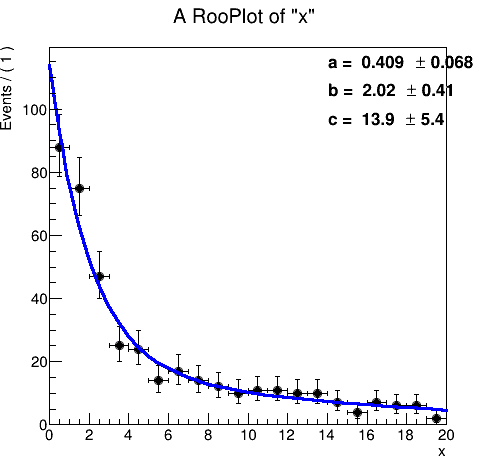

In [19]:
# Bin the data using RooDataHist

# note use of set obs, created above, to tell
# RooDataHist the variable(s) with respect to
# which the data are to be binned. the number of
# bins is obtained from the bin count attribute of "x"
# (see above)
hdata = ROOT.RooDataHist("hdata", "binned data", obs)
hdata.add(data)  # add the data to the RooDataHist and bin them
print("=" * 40)
hdata.Print("verbose")
print("=" * 40)

# Do a multinomial fit to the binned data by
# turning off extended likelihood mode. If you
# want a multi-Poisson fit, change False to True.
# (If interested, ask what all this means!)
results2 = model.fitTo(hdata, ROOT.RooFit.Save(), ROOT.RooFit.Extended(False))
results2.Print()

# Plot results of fit on a different frame
c2 = ROOT.TCanvas("fig_binnedFit", "fit", 500, 500)

xframe2 = wspace.var("x").frame()
xframe2.SetMaximum(0)
xframe2.SetMaximum(100)
hdata.plotOn(xframe2)
model.plotOn(xframe2)
model.paramOn(xframe2)
xframe2.Draw()
c2.Draw()
c2.SaveAs(".png")
print("=" * 80)

## PART 3: Do a bit of statisics
We shall compute two **goodness-of-fit** (gof) measures $X$ and $Y$.

\begin{align}
    X & = \sum_{i=1}^M \frac{(N_i - n_i)^2}{n_i}, \\
    Y & = -2 \log [ p(\boldsymbol{N} | \boldsymbol{n}) / p(\boldsymbol{N} | \boldsymbol{N})]
\end{align}

In [29]:
# Since we have binned data, we need to create an
# integral to integrate the model over each x-bin
# so that we can compare the expected count in a given
# bin with the observed count in that bin.
#
# 1. Define the set of variables over which to
# normalize the integral
normSet = ROOT.RooFit.NormSet(obs)

# 2. Define a range variable, call it x-bin, to
# represent the bin boundaries.
wspace.var("x").setRange("x-bin", xmin, xmax)

# 3. Create integral
integral = model.createIntegral(obs, normSet, ROOT.RooFit.Range("x-bin"))

# 4. We now compute two gof measures (with the
# restriction that the observed count N_i > 5)
# i.    X = sum_i=1^M (N_i - n_i)^2 / n_i,
#
# where n_i = int_bin_i f(x; theta_hat) dx
#
# ii.   Y = -2 ln p(N | n) / p(N | N),
#
# where p(N | n) is a multinomial likelihood; N denotes the counts
# N_1,...N_M and n denotes the mean counts. Note that n_i is
# evaluated at theta = theta_hat, that is, at the maximum
# likelihood (ML) estimates of the parameters of the model,
# here a, b, and c = theta.
#
# Let H_0 be the hypothesis that theta_0 are the true values
# of the parameters theta. In practice, we estimate theta_0 using
# ML and approximate theta_0 by theta_hat.
#
# According to Wilks' theorem (1938), the quantities X and Y have
# (asymptotically) a chi-squared distribution of M - P - 1
# degrees of freedom, where
#   M - number of bins
#   P - number of fitted parameters
#
# Procedure:
#   loop over bins
#     compute integral over bin to obtain n_i
#     accumulate X and Y with restriction that N_i > 5
#
#   compute p-value = Pr[X > X_obs]
#           p-value = Pr[Y > Y_obs]
#
# The hypothesis H_0: theta = theta_0 is to be rejected, that is, the 
# fit is declared "bad", if the p-value falls below some given threshold.
#
#
# Find bin width. Use float function to make sure we have
# a float in the numerator to avoid truncation (though this is
# not a problem in Python 3)
dx = float(xmax - xmin) / M
X  = 0.0
Y  = 0.0
total = 0.0  # to check the total integral (should be = N)
print("\n")
print("%5s\t%10s %5s %10s" % ("bin", "binlow", "count", "mean"))

# range(M) = [0, 1,...M-1]
K = 0  # count number of bins with N_i > 5
for ii in range(M):
    # Get count in bin ii
    # Yes, this is not as tidy as it could have been!
    ibin = hdata.get(ii)  # get object that models iith bin
    Ni   = hdata.weight() # get bin content (count)

    # Set the bin boundaries in our previously created
    # range object
    x = xmin + ii * dx
    wspace.var("x").setRange("x-bin", x, x + dx)

    # Compute the integral, with respect to x, over current
    # bin and scale result by the total observed count. This
    # gives us the mean count in the current bin
    ni = N * integral.getVal()
    print("{:5d}\t{:10.3f} {:5d} {:10.1f}".format(ii + 1, x, int(Ni), ni))

    total += ni
    if Ni < 5:
        continue

    # Accumulate X and Y
    K += 1
    X += (Ni - ni)**2 / ni
    Y += Ni * math.log(ni / Ni)

# Complete calculation of Y
Y *= -2

# 5. Assuming we are in asymptotia, compute
# p-value = Int_Y^infinity p(chi^2, ndf) dchi^2
# where p(chi^2, ndf) is the chi2 density of ndf
# degrees of freedom

ndf = K - P - 1  # number of degrees of freedom

if ndf > 0:
    pvalueX = ROOT.TMath.Prob(X, ndf)
    pvalueY = ROOT.TMath.Prob(Y, ndf)
else:
    pvalueX = 1.0
    pvalueY = 1.0
print("=" * 80)
print("Int p(x|xi) dx ={:6.1f}\n".format(total))

print("ChiSq/ndf = {:6.1f}/{:d} (using X)".format(X, ndf))
print("p-value   = {:9.4f}\n".format(pvalueX))

print("ChiSq/ndf = {:6.1f}/{:d} (using Y)".format(Y, ndf))
print("p-value   = %9.4f" % pvalueY)



  bin	    binlow count       mean
    1	     0.000    88       93.4
    2	     1.000    75       63.1
    3	     2.000    47       44.1
    4	     3.000    25       32.2
    5	     4.000    24       24.6
    6	     5.000    14       19.6
    7	     6.000    17       16.2
    8	     7.000    14       13.9
    9	     8.000    12       12.2
   10	     9.000    10       10.9
   11	    10.000    11        9.8
   12	    11.000    11        9.0
   13	    12.000    10        8.2
   14	    13.000    10        7.6
   15	    14.000     7        7.0
   16	    15.000     4        6.5
   17	    16.000     7        6.1
   18	    17.000     6        5.6
   19	    18.000     6        5.2
   20	    19.000     2        4.9
Int p(x|xi) dx = 400.0

ChiSq/ndf =    8.1/14 (using X)
p-value   =    0.8837

ChiSq/ndf =   18.9/14 (using Y)
p-value   =    0.1679
